# <i> <u> Predict booking cancellations by using XGBoost and LightGBM </u> </i>

Welcome to this code-along, where we will use XGBoost and LightGBM to predict booking cancellations with gradient boosting, a powerful ensemble machine learning technique! The purpose of this project is to <b> compare both algorithms </b> in terms of two metrics: 
- <b> AUC score </b> and 
- <b> F1-score </b>


### Dataset
The dataset was downloaded from [Kaggle](https://www.kaggle.com/competitions/playground-series-s3e7/data) and was generated from a deep learning model trained on the [Reservation Cancellation Prediction dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction).

### Data information

It contains the **19 columns**:

#### Target variable
- `booking_status`: Binary variable indicating whether a booking was canceled (0 - No, 1- Yes)

#### Features
- `id`: unique identifier of each booking
- `lead time`: Number of days between booking date and arrival date
- `no_of_adults`: Number of adults
- `no_of_children`: Number of children
- `no_of_weekend_nights`: Number of weekend nights (Saturday and Sunday)
- `no_of_week_nights`: Number of weeknights (Monday to Friday) the customer booked
- `type_of_meal_plan`: What type of meal customer booked
- `required_car_parking_spaces`: Number of parking spaces requested by the customer
- `room_type_reserved`: The type of room that was booked 
- `arrival_year`: The year of the arrival date
- `arrival_month`: The month of the arrival date
- `arrival_date`: The date of the arrival
- `market_segment_type`: Market segment designation
- `repeated_guest`: Is the customer a repeated guest? (0 - No, 1- Yes)
- `no_of_previous_cancellations`: Number of previous bookings that were canceled by the customer prior to the current booking
- `no_of_previous_bookings_not_canceled`: Number of previous bookings not canceled by the customer prior to the current booking
- `avg_price_per_room`: Average price per day of the reservation
- `no_of_special_requests`: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)

## Load the appropriate packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the data in a dataframe

In [3]:
data = pd.read_csv("train.csv")
display(data.head(3))

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0


## Data preparation

<b> 1) </b> By using the method info(), we observe that:
- There are no missing values.
- All variables are of type `int` except from `avg_price_per_room`, which is of type `float`.
- Some variables like (`room_typed_reserved`) may actually be categorical.

In [4]:
#getting some info about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    42100 non-null  int64  
 1   no_of_adults                          42100 non-null  int64  
 2   no_of_children                        42100 non-null  int64  
 3   no_of_weekend_nights                  42100 non-null  int64  
 4   no_of_week_nights                     42100 non-null  int64  
 5   type_of_meal_plan                     42100 non-null  int64  
 6   required_car_parking_space            42100 non-null  int64  
 7   room_type_reserved                    42100 non-null  int64  
 8   lead_time                             42100 non-null  int64  
 9   arrival_year                          42100 non-null  int64  
 10  arrival_month                         42100 non-null  int64  
 11  arrival_date   

<b> 2) </b> Let's explore the summary statistics by using the method `describe()`. It seems that some rooms have an average price of 0, which is not logical. Also, we can see that the minimum number of adults and children is also 0. What if we have records that have 0 for both variables `no_of_adults` & `no_of_children`? In both situations we have to drop these records accordingly.

In [5]:
data.describe()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000
mean,21049.500000,1.920713,0.141093,0.884632,2.398005,0.239192,0.025249,0.428931,103.888029,2017.856295,7.593539,15.902945,0.728504,0.029192,0.019715,0.175772,104.566377,0.571734,0.392019
std,12153.367503,0.524950,0.450128,0.885693,1.427330,0.587674,0.156884,0.832605,81.069343,0.350795,2.829395,8.888582,0.633529,0.168347,0.325837,1.732121,37.139165,0.775041,0.488207
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10524.750000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,37.000000,2018.000000,6.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000,0.000000
50%,21049.500000,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,93.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,31574.250000,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1.000000,155.000000,2018.000000,10.000000,24.000000,1.000000,0.000000,0.000000,0.000000,123.300000,1.000000,1.000000
max,42099.000000,4.000000,9.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


<b> i) </b> Dropping records that have 0 as `avg_price_per_room`.

In [6]:
#observing how many rows we have with 0 price
zero_price = data[data['avg_price_per_room']==0]
zero_price.shape

(641, 19)

In [7]:
#drop them
data.drop(zero_price.index, inplace=True)

In [8]:
#checking the shape again
print(data.shape)

(41459, 19)


<b> ii) </b> Dropping records that have 0 for both `no_of_adults` & `no_of_children`.

In [9]:
#observing how many rows we have with 0 no_of_adults & no_of_children
members = data[(data['no_of_adults']==0) & (data['no_of_children']==0)]
members.shape

(16, 19)

In [10]:
#drop them
data.drop(members.index, inplace=True)

In [11]:
#checking the shape again
print(data.shape)

(41443, 19)


<b> 3) </b> By looking at the variables, we can also see that:
- There is one variable concerning the number of adults (`no_of_adults`) and one variable concerning the number of children (`no_of_children`). It would be a good idea to create a feature that displays the total family members. In order to achieve this we will create a variable called `total_members`, which will be the sum of the two aforementioned ones.
- The same thing goes for the variables `no_of_weekend_nights` and `no_of_week_nights`. It would be nice to have the total number of nights that customers have booked. That's why, we will create a feature called `total_nights`.
- We could also create a date column called `arrival_date`.
- Finally, we will create a column called `price_over_members`.

In [12]:
# creating the feature total_members
data['total_members'] = data['no_of_adults'] + data['no_of_children']

#creating the feature total_nights
data['total_nights'] = data['no_of_weekend_nights'] + data['no_of_week_nights']

#creating a variable called price_over_total_members
data['price_over_members'] = round((data['avg_price_per_room'] / data['total_members']),3)

#creating the full arrival date column
data['arrival_fulldate'] = (data['arrival_year'].astype(str) 
                                   + '-' + data['arrival_month'].astype(str)
                                   + '-' + data['arrival_date'].astype(str))

In [13]:
#transform arrival date column to datetime
import datetime as dt

#it turns out that we have date for 29th of February (2018 is not a leap year),
#we have also dates for 2018-9-31, 2018-4-31, 2018-6-31, 2018-2-31, 2018-11-31, 2018-2-30, 2017-9-31
data.loc[data['arrival_fulldate'] == '2018-2-29','arrival_fulldate'] = '2018-2-28'
data.loc[data['arrival_fulldate'] == '2018-9-31','arrival_fulldate'] = '2018-9-30'
data.loc[data['arrival_fulldate'] == '2018-4-31','arrival_fulldate'] = '2018-4-30'
data.loc[data['arrival_fulldate'] == '2018-6-31','arrival_fulldate'] = '2018-6-30'
data.loc[data['arrival_fulldate'] == '2018-2-31','arrival_fulldate'] = '2018-2-28'
data.loc[data['arrival_fulldate'] == '2018-2-30','arrival_fulldate'] = '2018-2-28'
data.loc[data['arrival_fulldate'] == '2018-11-31','arrival_fulldate'] = '2018-11-30'
data.loc[data['arrival_fulldate'] == '2017-9-31','arrival_fulldate'] = '2018-9-30'
data['arrival_fulldate'] = pd.to_datetime(data['arrival_fulldate'])

In [14]:
#extract year, day and month again in order to have the correct values 
data['year'] = data['arrival_fulldate'].dt.year
data['month'] = data['arrival_fulldate'].dt.month
data['day'] = data['arrival_fulldate'].dt.day

In [15]:
#delete the old date columns
data.drop(['arrival_year','arrival_month','arrival_date'], axis = 1, inplace = True)

Now, let's drop the columns `id` and `booking_status` from the feature set. Finally, we will create a dataframe named `data_y` for the `booking_status` target variable.

In [16]:
#keeping only the features
data_x = data.drop(['id','booking_status'], axis = 1)

#isolating the dependent variable
data_y = data['booking_status']

<b> 4) </b> Now, let's answer another question: Do we have duplicates in our feature dataset? 
It seems that we have 1124 identical rows. Αfter analysis, it was discovered that these duplicate entries have the opposite `booking_status` value. That is, they are divided into records that have `booking_status` of 0 and 1. So, what we will do now? 
Τhe fact that we have duplicate records that differ in terms of the dependent variable can confuse the algorithm, as it won't really know how to categorize them. For this reason and due to the fact that the non-cancellation records are more than the cancellation ones, we will keep the records that have a `booking_status` value of 1 and those that have 0 will be deleted. This is done so that we have even more information regarding cancellations.

In [17]:
#do we have duplicates?
x=data_x.duplicated(keep=False)

#printing the shape
data_x[x].shape

(1124, 21)

In [18]:
#keeping the names of the duplicate columns
names = data_x.columns

#adding again the variable booking_status
data_x['booking_status'] = data_y

#return all the duplicates
x=data_x.duplicated(subset = names, keep=False)

In [19]:
#isolating duplicates in another dataset
data_dup = data_x[x]

#dropping the duplicates with booking_status 0
data_dup.drop(data_dup[data_dup['booking_status']==0].index, inplace=True)

In [20]:
#dropping duplicates from data_x dataset
data_x.drop(data_x[x].index, inplace = True)

In [21]:
#we want to concat (row-wise) to a new dataset: the data_x and the data_dup datasets
df = pd.concat([data_x, data_dup], axis=0)

In [22]:
#print the shape
print(df.shape)

(40880, 22)


Now, we have to split again the `df` in a dataframe that will contain the features and in another dataframe that will contain the target variable.

In [23]:
#isolating the features
data_features = df.drop('booking_status', axis=1)

#keeping the dependent variable
data_target = df['booking_status']

<b> 5) </b> Previously, it was mentioned that some variables might be categorical. That's why, we have to inspect the unique values of each feature in the `data_features` dataset.

In [24]:
#using the np.unique() function
unique_values = []
for i in data_features:
    unique_values = (list(np.unique(data_x[i])))
    print("The unique values of column {} are: ".format(i), unique_values)

The unique values of column no_of_adults are:  [0, 1, 2, 3, 4]
The unique values of column no_of_children are:  [0, 1, 2, 3, 4, 9]
The unique values of column no_of_weekend_nights are:  [0, 1, 2, 3, 4, 5, 6, 7]
The unique values of column no_of_week_nights are:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
The unique values of column type_of_meal_plan are:  [0, 1, 2, 3]
The unique values of column required_car_parking_space are:  [0, 1]
The unique values of column room_type_reserved are:  [0, 1, 2, 3, 4, 5, 6]
The unique values of column lead_time are:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 1

By looking at the unique values we can see that the variables:
- `type_of_meal_plan`
- `room_type_reserved`
- `market_segment_type`
- `repeated_guest`
- `required_car_parking_space`
- `booking_status`

<u> Have to be encoded as categorical </u>

We will encode this variables by using the `astype()` method.

In [25]:
colnames = ["type_of_meal_plan", "room_type_reserved","market_segment_type",
            "repeated_guest","required_car_parking_space"]
data_features[colnames] = data_features.loc[:,colnames].astype('category')
data_features.dtypes

no_of_adults                                     int64
no_of_children                                   int64
no_of_weekend_nights                             int64
no_of_week_nights                                int64
type_of_meal_plan                             category
required_car_parking_space                    category
room_type_reserved                            category
lead_time                                        int64
market_segment_type                           category
repeated_guest                                category
no_of_previous_cancellations                     int64
no_of_previous_bookings_not_canceled             int64
avg_price_per_room                             float64
no_of_special_requests                           int64
total_members                                    int64
total_nights                                     int64
price_over_members                             float64
arrival_fulldate                        datetime64[ns]
year      

Let's encode also the variable `booking_status` from the `data_y` dataframe as categorical.

In [26]:
data_target = data_target.astype('category')

## Data exploration for categorical values

Let's explore the categories by asking some questions:
- How many booking cancellations do we have?
- Which is the distribution of booking cancellations concerning the variable `type_of_meal_plan`?
- Which is the distribution of booking cancellations concerning the variable `required_car_parking_space`?
- Which is the distribution of booking cancellations concerning the variable `room_type_reserved`?
- Which is the distribution of booking cancellations concerning the variable `market_segment_type`?
- Which is the distribution of booking cancellations concerning the variable `repeated_guest`?

<b> 1) </b> How many booking cancellations do we have?

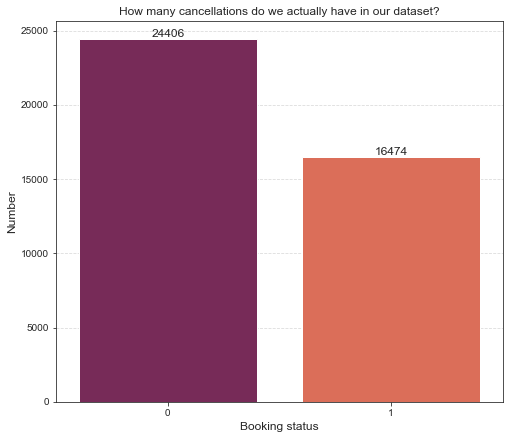

In [27]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8,7))
ax=sns.countplot(data_target, palette="rocket")
ax.set_xlabel("Booking status", fontsize=12)
ax.set_ylabel("Number", fontsize=12)
ax.set_title("How many cancellations do we actually have in our dataset?", fontsize=12)
ax.bar_label(ax.containers[0], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<b> 2) </b> Which is the distribution of booking cancellations concerning the variable `type_of_meal_plan`?

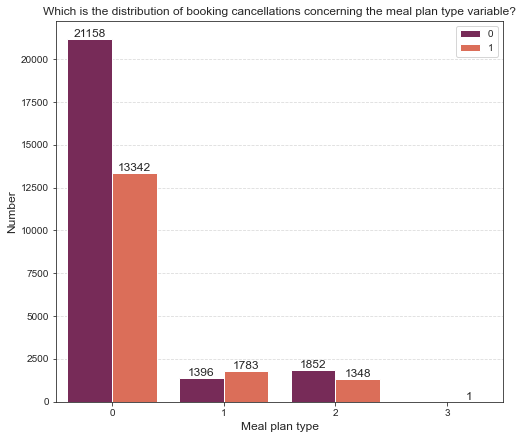

In [28]:
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(8, 7))
ax = sns.countplot(data=df, x="type_of_meal_plan", hue="booking_status", palette="rocket")
axes.set_xlabel("Meal plan type", fontsize=12)
axes.set_ylabel("Number", fontsize=12)
axes.set_title("Which is the distribution of booking cancellations concerning the meal plan type variable?", fontsize=12)
ax.bar_label(ax.containers[0], fontsize=12)
ax.bar_label(ax.containers[1], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc="upper right")
plt.show()

<b> 3) </b> What about the distribution of booking cancellations concerning the variable `required_car_parking_space`?

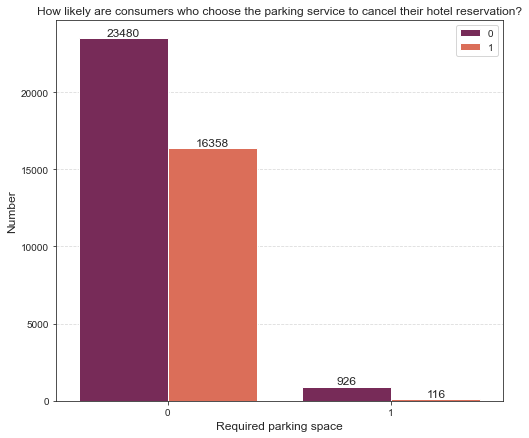

In [29]:
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(8, 7))
ax = sns.countplot(data=df, x="required_car_parking_space", hue="booking_status", palette="rocket")
axes.set_xlabel("Required parking space", fontsize=12)
axes.set_ylabel("Number", fontsize=12)
axes.set_title("How likely are consumers who choose the parking service to cancel their hotel reservation?", fontsize=12)
ax.bar_label(ax.containers[0], fontsize=12)
ax.bar_label(ax.containers[1], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc="upper right")
plt.show()

<b> 4) </b> Which is the distribution of booking cancellations concerning the variable `room_type_reserved`?

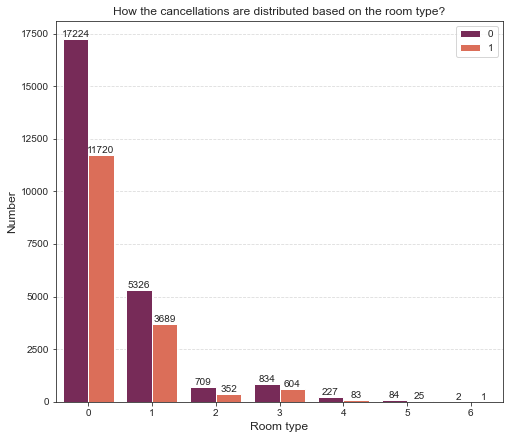

In [30]:
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(8, 7))
ax = sns.countplot(data=df, x="room_type_reserved", hue="booking_status", palette="rocket")
axes.set_xlabel("Room type", fontsize=12)
axes.set_ylabel("Number", fontsize=12)
axes.set_title("How the cancellations are distributed based on the room type?", fontsize=12)
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc="upper right")
plt.show()

<b> 5) </b> Which is the distribution of booking cancellations concerning the variable `market_segment_type`?

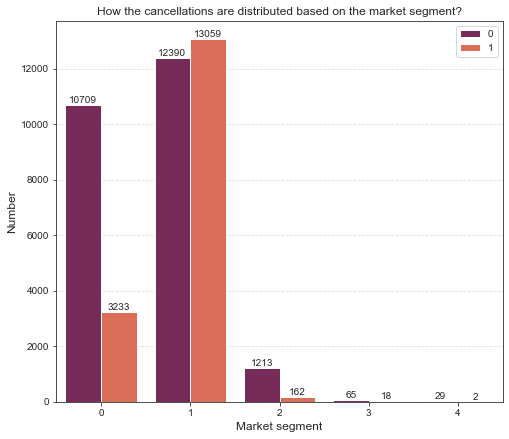

In [31]:
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(8, 7))
ax = sns.countplot(data=df, x="market_segment_type", hue="booking_status", palette="rocket")
axes.set_xlabel("Market segment", fontsize=12)
axes.set_ylabel("Number", fontsize=12)
axes.set_title("How the cancellations are distributed based on the market segment?", fontsize=12)
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc="upper right")
plt.show()

<b> 6) </b> Do `repeated_guest`s tend to cancel their reservations?

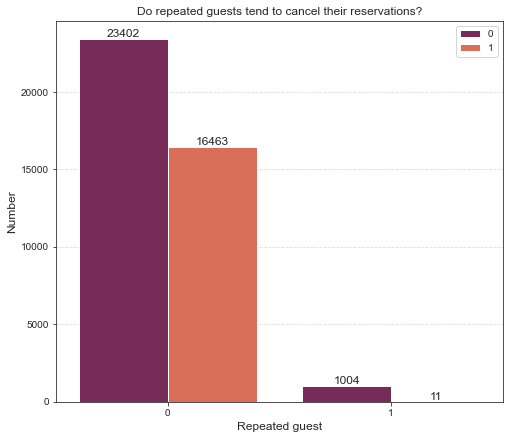

In [32]:
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(8, 7))
ax = sns.countplot(data=df, x="repeated_guest", hue="booking_status", palette="rocket")
axes.set_xlabel("Repeated guest", fontsize=12)
axes.set_ylabel("Number", fontsize=12)
axes.set_title("Do repeated guests tend to cancel their reservations?", fontsize=12)
ax.bar_label(ax.containers[0], fontsize=12)
ax.bar_label(ax.containers[1], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc="upper right")
plt.show()

## Data exploration for numerical values

At first, we will isolate the numerical values and create a correcalation matrix.

Text(0.5, 1.0, 'Correlation Heatmap')

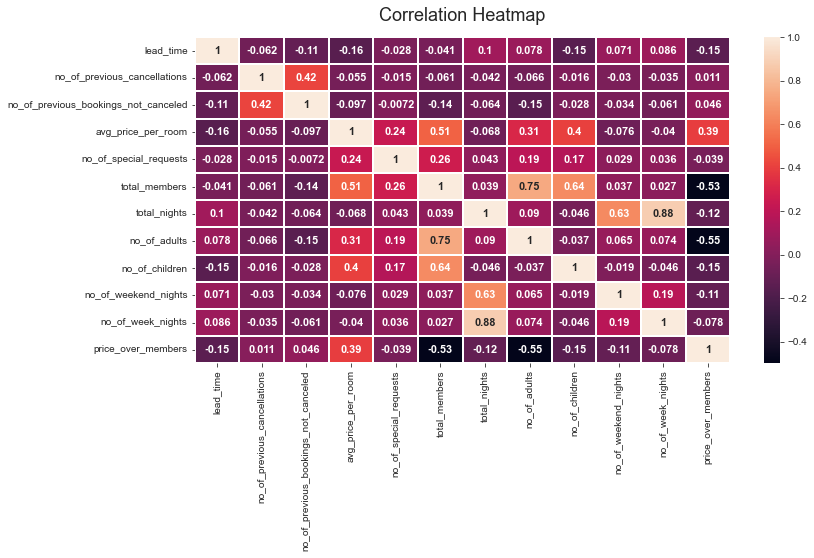

In [33]:
#create a heatmap for our numeric variables
data_num = data_features[['lead_time','no_of_previous_cancellations','no_of_previous_bookings_not_canceled',
                   'avg_price_per_room','no_of_special_requests',
                   'total_members','total_nights','no_of_adults','no_of_children',
                   'no_of_weekend_nights','no_of_week_nights','price_over_members']]

plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(data_num.corr(), annot=True, vmin=1, vmax=-0.5, 
                      annot_kws={'fontsize':11, 'fontweight':'bold'}, linewidth=2)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

Let's see the number of cancellations by date

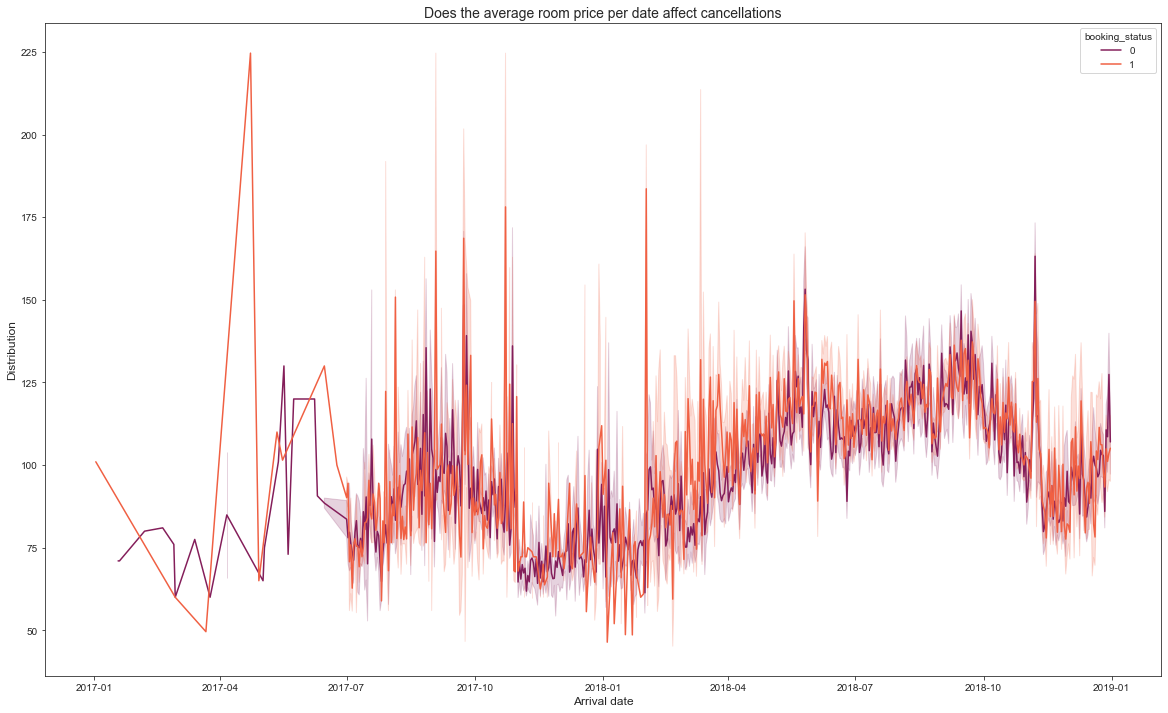

In [34]:
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(20, 12))
sns.lineplot(data=df, x="arrival_fulldate", y="avg_price_per_room", hue="booking_status", palette="rocket")
axes.set_xlabel("Arrival date", fontsize=12)
axes.set_ylabel("Distribution", fontsize=12)
axes.set_title("Does the average room price per date affect cancellations", fontsize=14)
plt.show()

## Dummy variables and Normalization

First, we will encode our categorical values by using the technique <b> get_dummies </b>. It is a strategy that encodes a nominal or categorical feature by assigning one binary column per category per categorical feature. We will encode the variables `type_of_meal_plan`, `room_type_reserved` and `market_segment_type` as the other categorical features have already binary values.

In [35]:
cat_var=['type_of_meal_plan','room_type_reserved','market_segment_type']

dummies = pd.get_dummies(data_features[cat_var], prefix=cat_var)

#concatenate the two dataframes
data_features = pd.concat([data_features, dummies], axis=1)

#remove the original cat variables from data_x
data_features.drop(cat_var, axis=1, inplace=True)

Now we will perform <b> min-max normalization </b> by using `MinMaxScaler()`.

In [36]:
data_features.drop(['arrival_fulldate'], axis=1, inplace=True)

In [37]:
#min - max normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_prep = scaler.fit_transform(data_features)
data_prep = pd.DataFrame(data_prep, columns = data_features.columns)

## Train and test the models

In [38]:
#split the data in train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_prep, data_target, test_size=.2, random_state=123, stratify=data_target)

For this project two ensemble algorithms where used: XGBoost & LightGBM. Both of them are ensemble methods, but the main difference is that in <b> XGBoost, trees grow depth-wise while in LightGBM, trees grow leaf-wise </b>.

### <b> <u> XGBoost Algorithm </u> </b>

Hyperparameter tuning was done, before we come up with these grid.

In [39]:
#defining our model
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score

xgb_param_grid = {"n_estimators":[500],
                "max_depth":[10],
                "learning_rate":[0.1], 
                'scale_pos_weight':[2],
                "min_child_weight":[10],
                'max_delta_step':[4]}

xgb = XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False, random_state=123)
cv_f = StratifiedKFold(n_splits=10, shuffle=True)
rand_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, n_jobs=2, cv=cv_f, verbose=1, scoring="roc_auc")
rand_search.fit(X_train, y_train)
preds = rand_search.predict(X_test)
print("The accuracy score is: ", round(accuracy_score(y_test,preds),3))
print("The f1 score is: ", round(f1_score(y_test,preds),3))
print("The precision score is: ", round(precision_score(y_test,preds),3))
print("The recall score is: ", round(recall_score(y_test,preds),3))
print(confusion_matrix(y_test, preds))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
The accuracy score is:  0.822
The f1 score is:  0.79
The precision score is:  0.751
The recall score is:  0.834
[[3969  912]
 [ 546 2749]]


In [40]:
from sklearn.metrics import roc_auc_score

# auc scores
pred_prob1 = rand_search.predict_proba(X_test)
auc_score_xgb = roc_auc_score(y_test, pred_prob1[:,1])

print("The AUC score is: ", round(auc_score_xgb,3))

The AUC score is:  0.906


Create the <b> confusion matrix </b>.

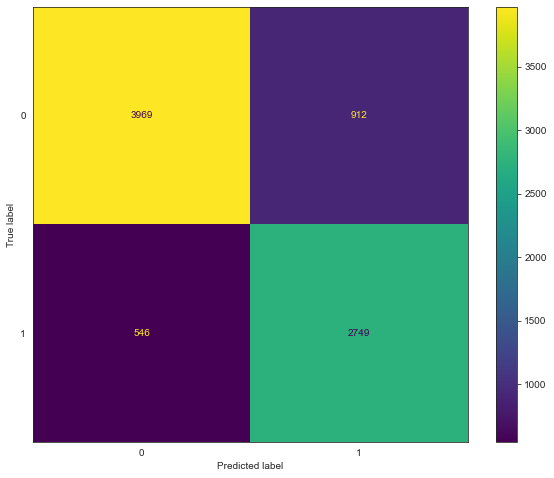

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rcParams['figure.figsize'] = (10.0, 8)
sns.set_style("white")
cm=confusion_matrix(y_test, preds, labels=rand_search.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rand_search.classes_)
disp.plot()
plt.show()

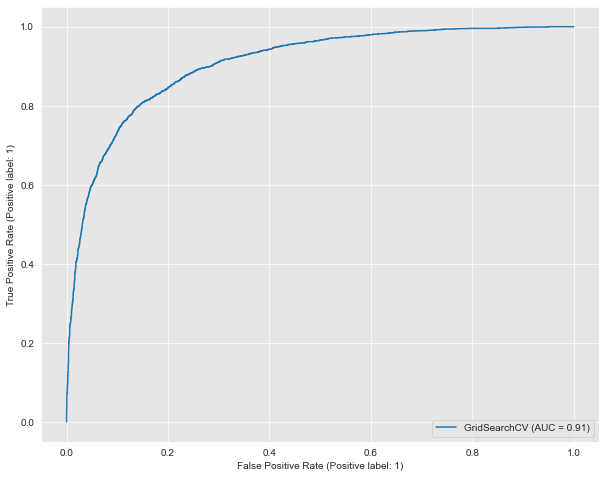

In [42]:
#now lets visualize our roc curve
from sklearn import metrics

plt.rcParams['figure.figsize'] = (10.0, 8)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
metrics.plot_roc_curve(rand_search, X_test, y_test)
plt.show()

XGBoost algorithm comes with a very useful visualization that is called feature importance.

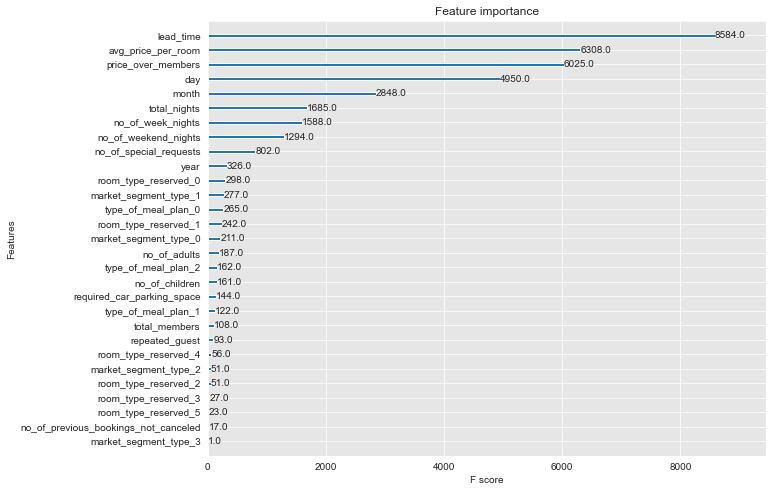

In [43]:
#plot the importance
from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt

xgb_clf = XGBClassifier(objective="binary:logistic", eval_metric="auc", 
                      random_state=123, n_estimators=500, max_depth=10, learning_rate=0.1, min_child_weight=10,
                      scale_pos_weight=2, max_delta_step=4, use_label_encoder=False)
xgb_clf.fit(X_train,y_train)

# Plot feature importance
plt.rcParams['figure.figsize'] = (10.0, 8)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plot_importance(xgb_clf)
plt.title("Feature importance")
plt.show()

### <b> <u> LightGBM Algorithm </u> </b>

In [44]:
import lightgbm as ltb
from lightgbm import LGBMClassifier

lgm_grid = {"n_estimators":[800],
            "max_depth":[10],
            "num_leaves":[40],
            "learning_rate":[0.1],
            "scale_pos_weight":[2],
            "min_split_gain":[0.5],
            "reg_alpha":[0.001]}

lgm = LGBMClassifier(random_state=123)
cv_f = StratifiedKFold(n_splits=10,shuffle=True)
rand_ser = GridSearchCV(estimator=lgm, param_grid=lgm_grid, n_jobs=2, cv=cv_f, verbose=1, scoring="roc_auc")
rand_ser.fit(X_train,y_train)
preds1 = rand_ser.predict(X_test)
print("The accuracy score is", round(accuracy_score(y_test,preds1),3))
print("The f1 score is", round(f1_score(y_test,preds1),3))
print("The precision score is", round(precision_score(y_test,preds1),3))
print("The recall score is", round(recall_score(y_test,preds1),3))
print(confusion_matrix(y_test, preds1))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
The accuracy score is 0.819
The f1 score is 0.793
The precision score is 0.735
The recall score is 0.86
[[3862 1019]
 [ 462 2833]]


In [45]:
from sklearn.metrics import roc_auc_score

# auc scores
pred_prob2 = rand_ser.predict_proba(X_test)
auc_score_lgm = roc_auc_score(y_test, pred_prob2[:,1])

print("The AUC score is: ", round(auc_score_lgm,3))

The AUC score is:  0.906


Create the <b> confusion matrix </b>.

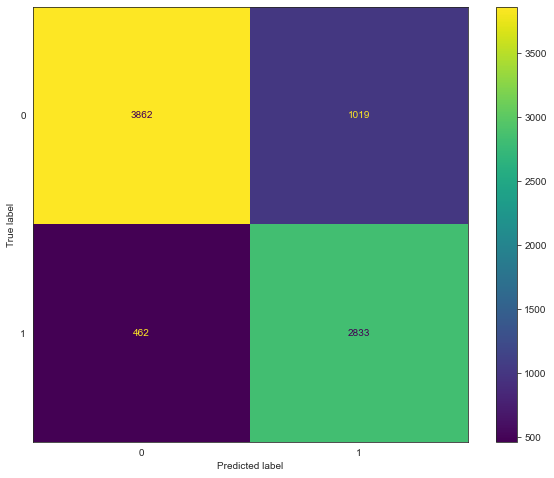

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_style("white")
cm=confusion_matrix(y_test, preds1, labels=rand_ser.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rand_ser.classes_)
disp.plot()
plt.show()

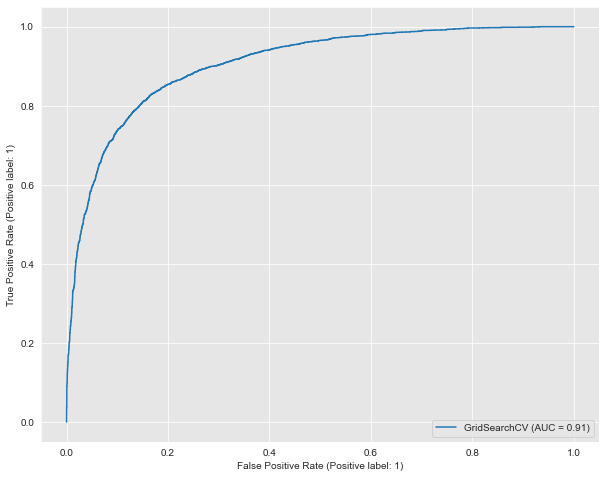

In [47]:
#now let's visualize our roc curve
from sklearn import metrics

plt.rcParams['figure.figsize'] = (10.0, 8)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
metrics.plot_roc_curve(rand_ser, X_test, y_test)
plt.show()

We can plot the importance also for LightGBM Algorithm.

In [48]:
#plot the weight
import lightgbm as ltb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

lgm_clf = LGBMClassifier(random_state=123, n_estimators=800, max_depth=7, learning_rate=0.1, 
                      scale_pos_weight=2, min_split_gain=0.5, reg_alpha=0.001, num_leaves=40)
lgm_clf.fit(X_train,y_train)

LGBMClassifier(max_depth=7, min_split_gain=0.5, n_estimators=800, num_leaves=40,
               random_state=123, reg_alpha=0.001, scale_pos_weight=2)

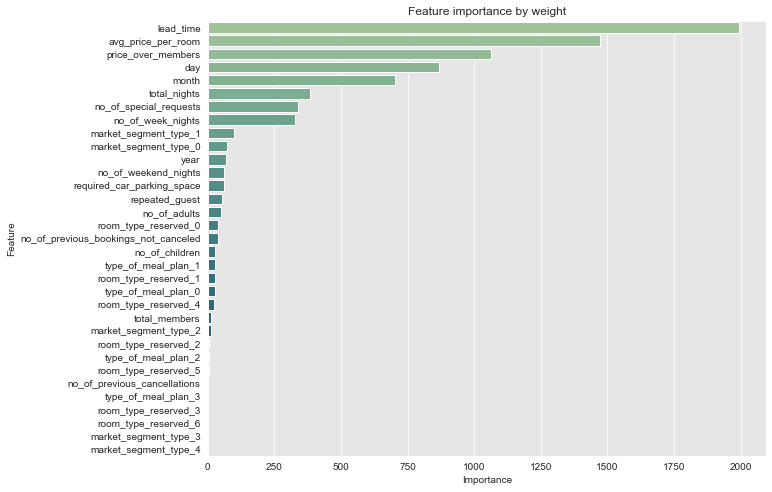

In [49]:
#feature importance by weight
#creat the dictionary first
feat_dict= {}
for col, val in sorted(zip(X_train.columns, lgm_clf.feature_importances_), key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

#df with importances
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})

#plot
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx, x=values, palette="crest").set(title='Important features to predict customer Churn')
plt.title("Feature importance by weight")
plt.show()

## Conclusion

- Both algorithms do an exceptional work in terms of the `AUC` and `f1-score` metrics. They achieve almost <b> 91% </b> and <b> 80% </b> respectively. 
- According to feature importance, it seems that for both boosting algorithms the features that carry a lot of weight are: `lead_time`, `avg_price_per_room`, `price_over_members`,`day`, `month`, `total_nights`,`no_of_special_requests` and `no_of_week_nights`.